# Analysis from Brian Goggin (uses newly-produced data as of September 2017)

In [90]:
import pandas as pd
import logging
import dateutil
from dateutil import parser
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [91]:
#import dataset of project times from "data" folder
file = "../../../data/cleaned/all_quarters__one_record_per_project.csv"
output="../../Output/"
df = pd.read_csv(file)

In [92]:
def comp_year(value):
    returnval=''
    if pd.isnull(value['comp_date']):
        returnval=''
    else:
        returnval=value['comp_date'][6:10]
    return returnval
df['comp_year']=df.apply(comp_year, axis=1)

In [93]:
def permit_year(value):
    returnval=''
    if pd.isnull(value['BP_date']):
        returnval=''
    else:
        returnval=value['BP_date'][0:4]
    return returnval
df['permit_year']=df.apply(permit_year, axis=1)

In [94]:
df.to_csv(output+"all_obs.csv") #requested by Manoj

# Initial Data Cleaning

In [95]:
#First, filter out those projects that are exclusively non-residential (defined as those without units)
df = df[df['units'] > 0]

In [96]:
df.shape

(3081, 29)

In [97]:
df=df[pd.notnull(df['firstfiled'])]
df=df[df['firstfiled'] !='']

In [98]:
df.shape

(2793, 29)

In [99]:
#drop BP duplicates for now—this suggests that they are likely duplicates. 
#This includes records with BP "MULTIPLE" because these are mostly mega projects and we don't want them in the sample
df['bp_duplicates']=df.duplicated('dbi_permit', keep=False)
df=df[(df['bp_duplicates']==False) | (pd.isnull(df['dbi_permit']))]

In [100]:
# make sure there are no duplicate first dates on same address-APN (aka drop those that have duplicate projects on same Address-APN combination)
df= df[~ df.duplicated(['address', 'apn', 'first_date'], keep=False)]

In [101]:
df.shape

(2475, 30)

In [102]:
df['project_time_years']=df['project_duration_days']/365

In [103]:
#Manual Data Cleaning for some fishy values based on top 5 shortest list above
#df.loc[(df['address']=='55 05TH ST') & (new_df['apn']=='3705039'), 'units'] = 8 #looked up on PIM. Simple adding 8 units.
#df.loc[(df['address']=='545 POST ST') & (new_df['apn']=='0306022'), 'units'] = 4 #looked up on PIM. Simple adding 4 units
#df.loc[(df['address']=='555 POST ST') & (new_df['apn']=='0306020'), 'units'] = 17 #looked up on PIM. Simple adding 4 units
#df.loc[(df['address']=='515 JOHN MUIR DR') & (new_df['apn']=='7282005'), 'units'] = 2 #looked up on PIM. Change of use to residential. 2 additional units

#based on the above cases, unit count seems to be the unit count at the site at the end of 
#the project rather than the unit count of the project itself. Because of this, I will be adjust
#unit counts that are more than the net units added to the net units added amount. If units net
#is missing, just accept unit count as true for now.

def unit_change(value):
    return_val=value['units']
    if pd.notnull(value['unitsnet']):
        if value['unitsnet']<0:
            return_val = value['units']
        elif value['unitsnet']==0:
            return_val = value['units']
        elif value['unitsnet']<value['units']:
            return_val = value['unitsnet']
        else:
            return_val=value['units']
    return return_val

df['units']=df.apply(unit_change, axis=1)
 

In [104]:
#Create Big Projects Dataframe
df_big=df[df['units']>=10]
df_big['project_time_years'].describe()

count    137.000000
mean       6.255254
std        3.453810
min        0.750685
25%        3.854795
50%        5.945205
75%        8.273973
max       24.128767
Name: project_time_years, dtype: float64

In [105]:
df['project_time_years'].describe()

count    721.000000
mean       4.426379
std        3.052768
min        0.430137
25%        2.043836
50%        3.717808
75%        6.109589
max       24.128767
Name: project_time_years, dtype: float64

# Merge in Geographic Information and Make Big Dataframe

In [106]:
#first, convert points to geodataframe
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.x, df.y)]
devs = GeoDataFrame(df, crs=crs, geometry=geometry)
devs = devs.to_crs({'init': 'epsg:4326'}) 

In [107]:
tracts = gpd.read_file("../../../data/Census/ACS_2015_5YR_TRACT_06_CALIFORNIA.gdb")
#convert boundaries to geographic coordinate system to conform to points
tracts = tracts.to_crs({'init': 'epsg:4326'}) 

Exception ignored in: <bound method Collection.__del__ of <open Collection '/Users/briangoggin/Dropbox/Fall 2017/CP 290/datasci-housing-pipeline/analysis/Output/dots.csv:dots', mode 'w' at 0x119720c18>>
Traceback (most recent call last):
  File "/Users/briangoggin/anaconda/lib/python3.5/site-packages/fiona/collection.py", line 416, in __del__
    self.__exit__(None, None, None)
  File "/Users/briangoggin/anaconda/lib/python3.5/site-packages/fiona/collection.py", line 411, in __exit__
    self.close()
  File "/Users/briangoggin/anaconda/lib/python3.5/site-packages/fiona/collection.py", line 395, in close
    self.flush()
  File "/Users/briangoggin/anaconda/lib/python3.5/site-packages/fiona/collection.py", line 384, in flush
    if self.session is not None and self.session.get_length() > 0:
  File "fiona/ogrext.pyx", line 495, in fiona.ogrext.Session.get_length (fiona/ogrext.c:9385)
ValueError: Null layer


In [108]:
tables = ['B25003', 'B19001', 'B01001', 'B02001', 'S0101', 'S1901', 'B25077', 'B25038']

In [109]:
for table in tables: 
    new_table = pd.read_csv("../../../data/Census/ACS_15_5YR_"+table+"_with_ann.csv", header=1)
    new_table = new_table.drop(['Id', 'Geography'], axis=1) #drop unnecessary variables
    new_table = new_table[new_table.columns.drop(list(new_table.filter(regex='Margin of Error')))] #drop MOE columns for now
    new_table = new_table.rename(columns={'Estimate; Total:': 'Estimate; Total:'+'_'+table}) #rename estimate "total" column
    new_table['Id2']=new_table['Id2'].astype(str).apply(lambda x: x.zfill(11))
    tracts = pd.merge(tracts, new_table, left_on='GEOID', right_on='Id2', how='inner') #inner join to get rid of non-SF tracts

In [110]:
tracts.head()

,ALAND,AWATER,COUNTYFP,FUNCSTAT,GEOID,GEOID_Data,INTPTLAT,INTPTLON,MTFCC,NAME,NAMELSAD,STATEFP,Shape_Area,Shape_Length,TRACTCE,geometry,Id2_x,Estimate; Total:_B25003,Estimate; Total: - Owner occupied,Estimate; Total: - Renter occupied,Id2_y,Estimate; Total:_B19001,"Estimate; Total: - Less than $10,000","Estimate; Total: - $10,000 to $14,999","Estimate; Total: - $15,000 to $19,999","Estimate; Total: - $20,000 to $24,999","Estimate; Total: - $25,000 to $29,999","Estimate; Total: - $30,000 to $34,999","Estimate; Total: - $35,000 to $39,999","Estimate; Total: - $40,000 to $44,999","Estimate; Total: - $45,000 to $49,999","Estimate; Total: - $50,000 to $59,999","Estimate; Total: - $60,000 to $74,999","Estimate; Total: - $75,000 to $99,999","Estimate; Total: - $100,000 to $124,999","Estimate; Total: - $125,000 to $149,999","Estimate; Total: - $150,000 to $199,999","Estimate; Total: - $200,000 or more",Id2_x,Estimate; Total:_B01001,Estimate; Male:,Estimate; Male: - Under 5 years,Estimate; Male: - 5 to 9 years,Estimate; Male: - 10 to 14 years,Estimate; Male: - 15 to 17 years,Estimate; Male: - 18 and 19 years,Estimate; Male: - 20 years,Estimate; Male: - 21 years,Estimate; Male: - 22 to 24 years,Estimate; Male: - 25 to 29 years,Estimate; Male: - 30 to 34 years,Estimate; Male: - 35 to 39 years,Estimate; Male: - 40 to 44 years,Estimate; Male: - 45 to 49 years,Estimate; Male: - 50 to 54 years,Estimate; Male: - 55 to 59 years,Estimate; Male: - 60 and 61 years,Estimate; Male: - 62 to 64 years,Estimate; Male: - 65 and 66 years,Estimate; Male: - 67 to 69 years,Estimate; Male: - 70 to 74 years,Estimate; Male: - 75 to 79 years,Estimate; Male: - 80 to 84 years,Estimate; Male: - 85 years and over,Estimate; Female:,Estimate; Female: - Under 5 years,Estimate; Female: - 5 to 9 years,Estimate; Female: - 10 to 14 years,Estimate; Female: - 15 to 17 years,Estimate; Female: - 18 and 19 years,Estimate; Female: - 20 years,Estimate; Female: - 21 years,Estimate; Female: - 22 to 24 years,Estimate; Female: - 25 to 29 years,Estimate; Female: - 30 to 34 years,Estimate; Female: - 35 to 39 years,Estimate; Female: - 40 to 44 years,Estimate; Female: - 45 to 49 years,Estimate; Female: - 50 to 54 years,Estimate; Female: - 55 to 59 years,Estimate; Female: - 60 and 61 years,Estimate; Female: - 62 to 64 years,Estimate; Female: - 65 and 66 years,Estimate; Female: - 67 to 69 years,Estimate; Female: - 70 to 74 years,Estimate; Female: - 75 to 79 years,Estimate; Female: - 80 to 84 years,Estimate; Female: - 85 years and over,Id2_y,Estimate; Total:_B02001,Estimate; Total: - White alone,Estimate; Total: - Black or African American alone,Estimate; Total: - American Indian and Alaska Native alone,Estimate; Total: - Asian alone,Estimate; Total: - Native Hawaiian and Other Pacific Islander alone,Estimate; Total: - Some other race alone,Estimate; Total: - Two or more races:,Estimate; Total: - Two or more races: - Two races including Some other race,"Estimate; Total: - Two or more races: - Two races excluding Some other race, and three or more races",Id2_x,Total; Estimate; Total population,Male; Estimate; Total population,Female; Estimate; Total population,Total; Estimate; AGE - Under 5 years,Male; Estimate; AGE - Under 5 years,Female; Estimate; AGE - Under 5 years,Total; Estimate; AGE - 5 to 9 years,Male; Estimate; AGE - 5 to 9 years,Female; Estimate; AGE - 5 to 9 years,Total; Estimate; AGE - 10 to 14 years,Male; Estimate; AGE - 10 to 14 years,Female; Estimate; AGE - 10 to 14 years,Total; Estimate; AGE - 15 to 19 years,Male; Estimate; AGE - 15 to 19 years,Female; Estimate; AGE - 15 to 19 years,Total; Estimate; AGE - 20 to 24 years,Male; Estimate; AGE - 20 to 24 years,Female; Estimate; AGE - 20 to 24 years,Total; Estimate; AGE - 25 to 29 years,Male; Estimate; AGE - 25 to 29 years,Female; Estimate; AGE - 25 to 29 years,Total; Estimate; AGE - 30 to 34 years,Male; Estimate; AGE - 30 to 34 years,Female; Estimate; AGE - 30 to 34 years,Total; Estimate; AGE - 35 to 39 years,Male; Estimate; AGE

In [111]:
#consolidate income categories
twentyfive=['Estimate; Total: - Less than $10,000', 'Estimate; Total: - $10,000 to $14,999', 
           'Estimate; Total: - $15,000 to $19,999', 'Estimate; Total: - $20,000 to $24,999']

fifty = ['Estimate; Total: - $25,000 to $29,999', 'Estimate; Total: - $30,000 to $34,999',
        'Estimate; Total: - $35,000 to $39,999', 'Estimate; Total: - $40,000 to $44,999',
        'Estimate; Total: - $45,000 to $49,999']
         
seven_five=['Estimate; Total: - $50,000 to $59,999','Estimate; Total: - $60,000 to $74,999']
           
hundred = ['Estimate; Total: - $75,000 to $99,999']
greater_hundred = ['Estimate; Total: - $100,000 to $124,999', 'Estimate; Total: - $125,000 to $149,999',
                  'Estimate; Total: - $150,000 to $199,999', 'Estimate; Total: - $200,000 or more']

tracts['0-25']=tracts[twentyfive].sum(axis=1)
tracts['25-50']=tracts[fifty].sum(axis=1)
tracts['50-75']=tracts[seven_five].sum(axis=1)
tracts['75-100']=tracts[hundred].sum(axis=1)
tracts['>100']=tracts[greater_hundred].sum(axis=1)

In [112]:
#consolidate age categories
male='Estimate; Male: - '
female='Estimate; Female: - '
teen=['Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 17 years']
adult=['18 and 19 years', '20 years','21 years', '22 to 24 years',
      '25 to 29 years','30 to 34 years','35 to 39 years']
middle=['40 to 44 years','45 to 49 years','50 to 54 years','55 to 59 years']
old=['60 and 61 years','62 to 64 years','65 and 66 years','67 to 69 years',
    '70 to 74 years','75 to 79 years','80 to 84 years','85 years and over']

teen_cats=[]
adult_cats=[]
middle_cats=[]
old_cats=[]
for cat in teen:
    teen_cats.append(male+cat)
    teen_cats.append(female+cat)
for cat in adult:
    adult_cats.append(male+cat)
    adult_cats.append(female+cat)
for cat in middle:
    middle_cats.append(male+cat)
    middle_cats.append(female+cat)
for cat in old:
    old_cats.append(male+cat)
    old_cats.append(female+cat)
tracts['teen']=tracts[teen_cats].sum(axis=1)
tracts['adult']=tracts[adult_cats].sum(axis=1)
tracts['middle']=tracts[middle_cats].sum(axis=1)
tracts['old']=tracts[old_cats].sum(axis=1)

In [113]:
#Consolidate "moved-in" categories
times=['Moved in 2015 or later', 'Moved in 2010 to 2014', 'Moved in 2000 to 2009','Moved in 1990 to 1999', 'Moved in 1980 to 1989', 'Moved in 1979 or earlier']

for period in times:
    tracts['total: '+period]=tracts['Estimate; Owner occupied: - '+ period]+tracts['Estimate; Renter occupied: - '+ period]

In [114]:
#Create variables to explore
tracts['perc_old']=(tracts['old']/tracts['Estimate; Total:_B01001'])*100
tracts['perc_white']=(tracts['Estimate; Total: - White alone']/tracts['Estimate; Total:_B02001'])*100
tracts['perc_rich']=(tracts['>100']/tracts['Estimate; Total:_B01001'])*100
tracts['pop_density']=tracts['Estimate; Total:_B01001']/(tracts['ALAND']*(0.000000386102)) #convert to pop per square miles (from square meters)
tracts['perc_owner']=(tracts['Estimate; Total: - Owner occupied']/tracts['Estimate; Total:_B25003'])*100
tracts['median_age']=tracts['Total; Estimate; SUMMARY INDICATORS - Median age (years)']
tracts['median_income']=tracts['Households; Estimate; Median income (dollars)']
tracts.loc[(tracts['median_age']=='-'), 'median_age'] = 'nan'
tracts.loc[(tracts['median_income']=='-'), 'median_income'] = 'nan'
tracts.loc[(tracts['median_income']=='(X)'), 'median_income'] = 'nan'
tracts['median_age']=tracts['median_age'].astype(float)
tracts['median_income']=tracts['median_income'].astype(float)
tracts['median_homevalue']=tracts['Estimate; Median value (dollars)']
tracts.loc[(tracts['median_homevalue']=='-'), 'median_homevalue'] = 'nan'
tracts.loc[(tracts['median_homevalue']=='2,000,000+'), 'median_homevalue'] = '2000000' #round down to 2 million for these
tracts['median_homevalue']=tracts['median_homevalue'].astype(float)
#percentage pre-2000 and pre-1990 move-in
tracts['perc_pre_2000']=((tracts['total: Moved in 1980 to 1989']+tracts['total: Moved in 1990 to 1999']+tracts['total: Moved in 1979 or earlier'])/tracts['Estimate; Total:_B25038'])*100
tracts['perc_pre_1990']=((tracts['total: Moved in 1980 to 1989']+tracts['total: Moved in 1979 or earlier'])/tracts['Estimate; Total:_B25038'])*100
#tracts['perc_pre_2000'].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8,.9])
#tracts['perc_pre_1990'].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8,.9])

In [115]:
#make series of scatter plots, correlation graphs. Population density, age, income, tenure, race, home age.
varlist=['GEOID', 'geometry', 'perc_owner', 'pop_density', 'perc_old', 'perc_rich', 'perc_white', 
         'median_age', 'median_income', 'median_homevalue', 'perc_pre_2000', 'perc_pre_1990'] #keep only certain variables
tracts=tracts[varlist]

In [116]:
#Check plots 
#tracts.plot(column='perc_rich', cmap='OrRd')
#plt.xlim([-122.58, -122.18])
#plt.ylim([37.7, 37.82])

In [117]:
#First, spatial join between points and neighborhood boundaries. Set 'how' to 'left' to preserve all developments
df = gpd.sjoin(devs, tracts, how = 'inner', op='within')

In [118]:
# a few projects appear to be outside tract boundaries so they are dropped here. not too many so I'm not worried about them too much. 
#base=tracts.plot(color='white', linewidth=.1)
#devs.plot(ax=base)
#plt.xlim([-122.58, -122.18])
#plt.ylim([37.7, 37.82])

In [119]:
df.head()

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,dropped_out,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,comp_year,permit_year,bp_duplicates,project_time_years,geometry,index_right,GEOID,perc_owner,pop_density,perc_old,perc_rich,perc_white,median_age,median_income,median_homevalue,perc_pre_2000,perc_pre_1990
0,0,NaN,751 WEBSTER ST,0797003,2013-03-28,BP FILED,NaN,NaN,201303283273,True,2013-03-28,2013-03-28,2013-03-28,2013-03-28,BP FILED,"('2013-03-28', '2013-03-28', '2013-03-28', '20...",NaN,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",1,2016,Proposed,1.0,1.0,-122.430139,37.777629,RH-3,RH-3,,,False,NaN,POINT (-122.430139 37.7776287614),88,06075016300,20.221886,48699.174557,12.329656,19.943759,55.678131,34.0,86940.0,794000.0,33.383762,7.967726
291,0,NaN,890 GROVE ST,0797019,NaN,PL APPROVED,NaN,2014-05-27,201003107932,False,2010-02-16,2010-07-09,2010-02-16,NaN,PL APPROVED,"('2010-07-09', '2010-07-09', '2010-07-09', '20...",NaN,"('PL APPROVED', 'PL APPROVED', 'PL APPROVED', ...",2,2013,Proposed,1.0,1.0,-122.431228,37.776981,RH-3,RH-3,,,False,NaN,POINT (-122.431228 37.776981),88,06075016300,20.221886,48699.174557,12.329656,19.943759,55.678131,34.0,86940.0,794000.0,33.383762,7.967726
625,0,2016-06-10,628 IVY ST,0805034,2016-06-10,BP ISSUED,NaN,NaN,201504022691,False,2015-04-02,2015-04-02,2015-04-02,2016-06-10,BP ISSUED,"('2015-04-02', '2015-04-02', '2015-04-02', '20...",NaN,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",2,2017,Building Permit Approved,1.0,1.0,-122.428596,37.776775,NaN,NaN,,2016,False,NaN,POINT (-122.4285964966 37.7767753601),88,06075016300,20.221886,48699.174557,12.329656,19.943759,55.678131,34.0,86940.0,794000.0,33.383762,7.967726
2051,0,NaN,802-808 STEINER ST (BLDG 3 OF 3),0798055,2014-02-13,PL APPROVED,NaN,NaN,201109144616,True,2014-01-03,2014-02-13,2014-01-03,2014-02-13,PL APPROVED,"('2014-02-13',)",NaN,"('PL APPROVED',)",4,2016,Proposed,1.0,1.0,-122.432786,37.777030,RH-3,RH-3,,,False,NaN,POINT (-122.432786084 37.7770298898),88,06075016300,20.221886,48699.174557,12.329656,19.943759,55.678131,34.0,86940.0,794000.0,33.383762,7.967726
2107,0,2014-08-22,564 FELL ST,0819011,2015-05-07,CONSTRUCTION,10/01/2015,2015-05-07,201303283325,False,2013-03-28,2013-03-28,2013-03-28,2015-05-07,CONSTRUCTION,"('2013-03-28', '2013-03-28', '2013-03-28', '20...",917.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",3,2015,Under Construction,1.0,1.0,-122.427128,37.775597,RTO,RTO,2015,2014,False,2.512329,POINT (-122.427127741 37.7755972585),88,06075016300,20.221886,48699.174557,12.329656,19.943759,55.678131,34.0,86940.0,794000.0,33.383762,7.967726


# Joint Scatter Plot Graphs

In [120]:
df['years_per_unit']=df['project_time_years']/df['units']

In [121]:
df[pd.notnull(df['project_time_years'])].shape

(716, 45)

In [123]:
df_export.head()

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,dropped_out,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,comp_year,permit_year,bp_duplicates,project_time_years,geometry,index_right,GEOID,perc_owner,pop_density,perc_old,perc_rich,perc_white,median_age,median_income,median_homevalue,perc_pre_2000,perc_pre_1990,years_per_unit
2107,0,2014-08-22,564 FELL ST,0819011,2015-05-07,CONSTRUCTION,10/01/2015,2015-05-07,201303283325,False,2013-03-28,2013-03-28,2013-03-28,2015-05-07,CONSTRUCTION,"('2013-03-28', '2013-03-28', '2013-03-28', '20...",917.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",3,2015,Under Construction,1.0,1.0,-122.427128,37.775597,RTO,RTO,2015,2014,False,2.512329,POINT (-122.427127741 37.7755972585),88,06075016300,20.221886,48699.174557,12.329656,19.943759,55.678131,34.0,86940.0,794000.0,33.383762,7.967726,2.512329
2224,0,2013-11-22,526 HICKORY ST,0829023,2015-01-21,CONSTRUCTION,01/01/2017,2014-09-16,201209200264,False,2012-09-20,2012-09-20,2012-09-20,2015-01-21,CONSTRUCTION,"('2012-09-20', '2012-09-20', '2012-09-20', '20...",1564.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",4,2016,Under Construction,1.0,1.0,-122.428681,37.774938,RH-3,RH-3,2017,2013,False,4.284932,POINT (-122.428681361 37.7749379125),88,06075016300,20.221886,48699.174557,12.329656,19.943759,55.678131,34.0,86940.0,794000.0,33.383762,7.967726,4.284932
3058,0,NaN,840 FELL ST,0822014,2009-10-22,CONSTRUCTION,04/01/2010,2009-09-14,200712311639,False,2007-12-31,2009-09-14,2007-12-31,2009-10-22,CONSTRUCTION,"('2009-09-14', '2009-10-22', '2009-10-22')",822.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION')",1,2010,Under Construction,1.0,1.0,-122.431732,37.774933,RM-1,RM-1,2010,,False,2.252055,POINT (-122.431732 37.774933),88,06075016300,20.221886,48699.174557,12.329656,19.943759,55.678131,34.0,86940.0,794000.0,33.383762,7.967726,2.252055
393,0,NaN,834 44TH AV,1686033,2006-06-29,CONSTRUCTION,04/01/2015,2006-06-29,200412161565,False,2004-12-16,2006-06-29,2004-12-16,2006-06-29,CONSTRUCTION,"('2006-06-29', '2006-06-29', '2006-06-29', '20...",3758.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",1,2015,Under Construction,1.0,1.0,-122.504300,37.772800,RH-2,RH-2,2015,,False,10.295890,POINT (-122.504299628 37.7728000128),169,06075047901,58.241758,15240.832866,25.666424,15.061908,48.113620,42.9,66437.0,844600.0,39.977264,22.925351,10.295890
907,0,NaN,701 43RD AV,1601001,2008-12-31,CONSTRUCTION,04/01/2013,2008-12-31,200710155396,False,2007-06-26,2008-12-31,2007-06-26,2008-12-31,CONSTRUCTION,"('2008-12-31', '2008-12-31', '2008-12-31', '20...",2106.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",1,2013,Under Construction,1.0,1.0,-122.503878,37.775204,RH-2,RH-2,2013,,False,5.769863,POINT (-122.503878 37.775204),169,06075047901,58.241758,15240.832866,25.666424,15.061908,48.113620,42.9,66437.0,844600.0,39.977264,22.925351,5.769863


# Interuption: Export Shapefile

In [ ]:
def permit_time(value):
    returnval=np.nan
    if pd.notnull(value['BP_date']) & pd.notnull(value['first_date']):
        returnval=((dateutil.parser.parse(value['BP_date']) - dateutil.parser.parse(value['first_date'])).days)/365
    return returnval
def bp_time(value):
    returnval=np.nan
    if pd.notnull(value['con_date']) & pd.notnull(value['BP_date']):
        returnval=((dateutil.parser.parse(value['con_date']) - dateutil.parser.parse(value['BP_date'])).days)/365
    return returnval
def con_time(value):
    returnval=np.nan
    if pd.notnull(value['comp_date']) & pd.notnull(value['con_date']):
        returnval=((dateutil.parser.parse(value['comp_date']) - dateutil.parser.parse(value['con_date'])).days)/365
    return returnval
    
df_export['permit_time']=df_export.apply(permit_time, axis=1)
df_export['bp_time']=df_export.apply(bp_time, axis=1)
df_export['con_time']=df_export.apply(con_time, axis=1)

In [ ]:
df_export['years_per_unit']=df_export['project_time_years']/df_export['units']
df_export['ptime_per_unit']=df_export['permit_time']/df_export['units']

In [124]:
#df_export=df[pd.notnull(df['project_time_years'])]
df_export=df_export[['address', 'apn', 'x', 'y', 'geometry', 'years_per_unit', 'ptime_per_unit']]
df_export.to_file(driver='ESRI Shapefile',filename=output+"dots.shp")
df_export.to_csv(output+"dots.csv")

# End Interuption

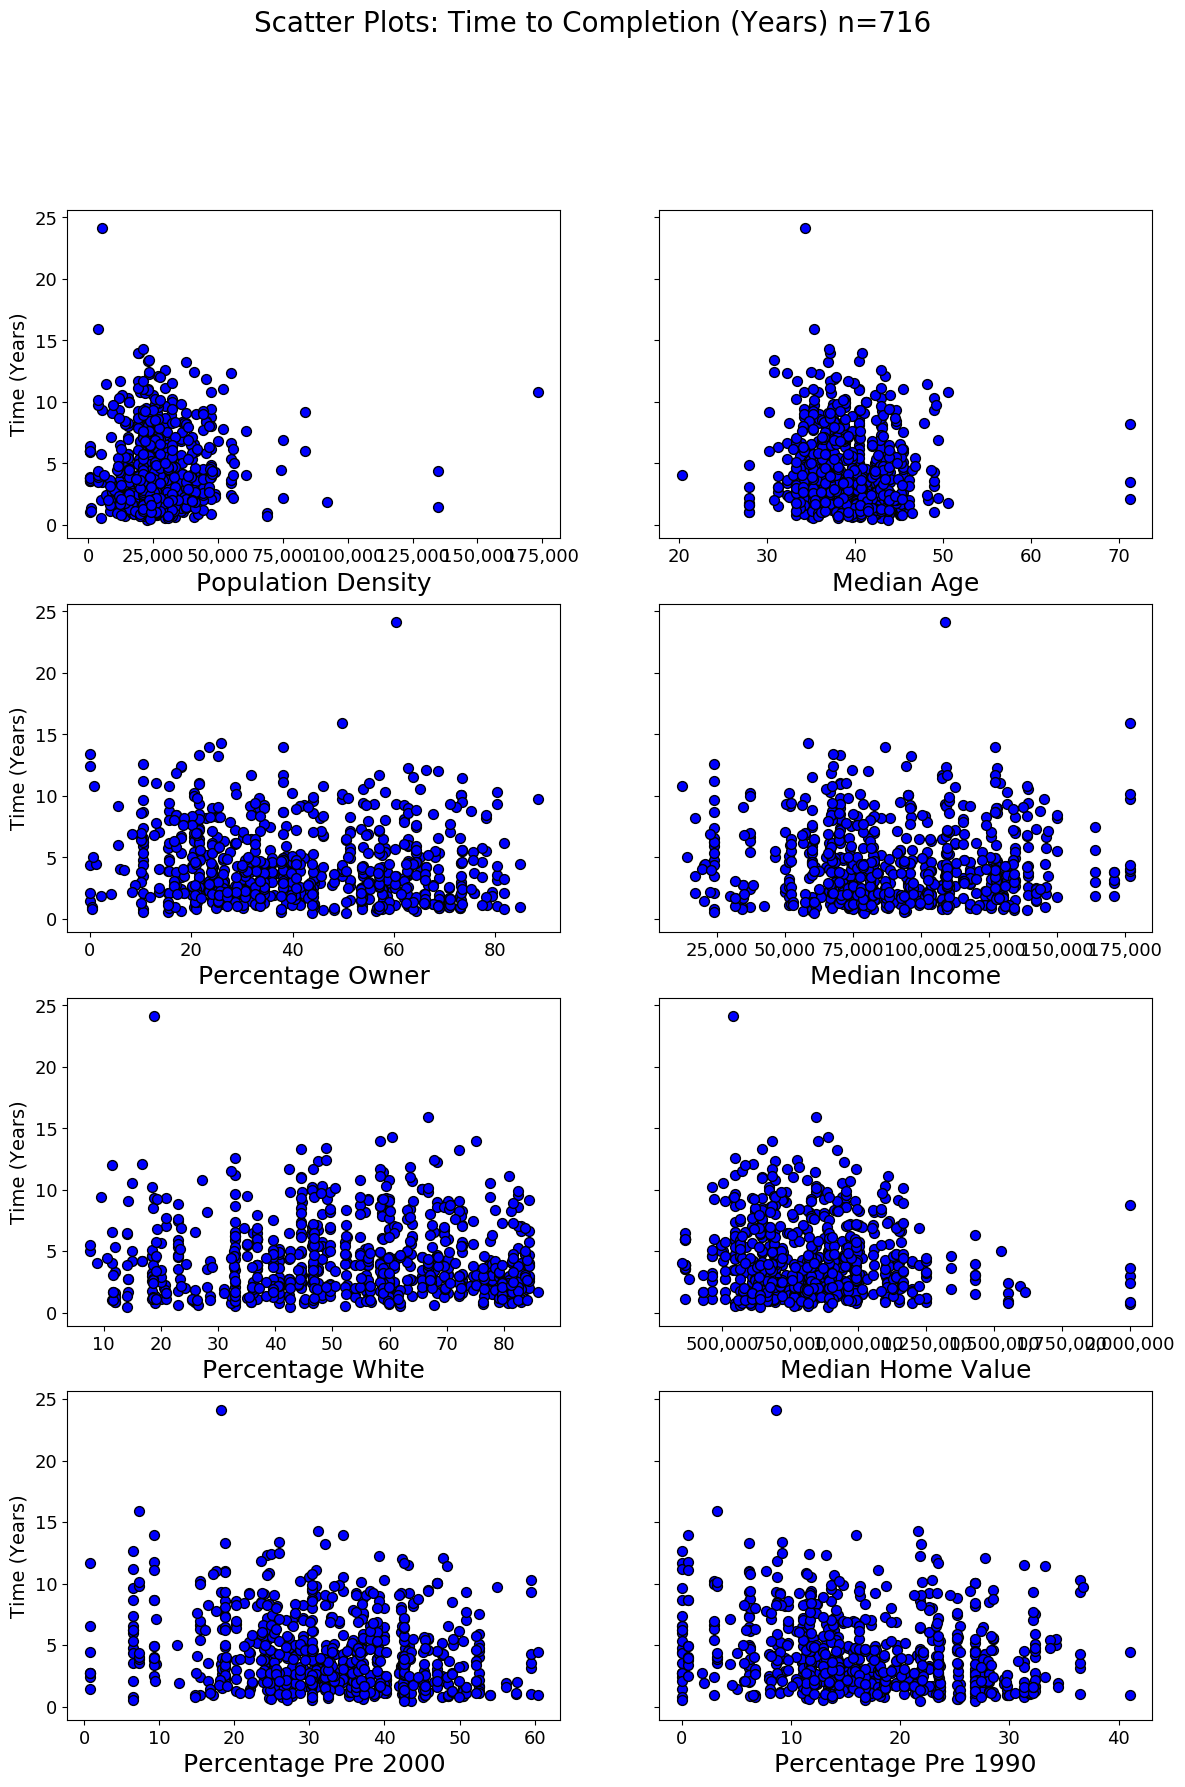

In [33]:
def joint_scatter(variable, title, yaxis,file, df=df, color='blue'):
    fig, ax = plt.subplots(4, 2, figsize=(14,20), sharey=True)
    sample_size=df[pd.notnull(df[variable])][variable].count()
    plt.suptitle(title+ " n="+str(sample_size), fontsize=20)
    #plt.ylim([0,25])
    for m in range(4):
        for n in range(2):
            ax[m, n].tick_params(axis='both', which='major', labelsize=13)
            ax[m, n].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    dotsize=50
    ax[0, 0].scatter(df['pop_density'], df[variable], s=dotsize, color=color, edgecolors='black')
    ax[0, 0].set_xlabel('Population Density', fontsize=18)
    ax[0, 0].set_ylabel(yaxis, fontsize=14)
    ax[1, 0].scatter(df['perc_owner'], df[variable], s=dotsize, color=color, edgecolors='black')
    ax[1, 0].set_xlabel('Percentage Owner', fontsize=18)
    ax[1, 0].set_ylabel(yaxis, fontsize=14)
    ax[2, 0].scatter(df['perc_white'], df[variable], s=dotsize, color=color, edgecolors='black')
    ax[2, 0].set_xlabel('Percentage White', fontsize=18)
    ax[2, 0].set_ylabel(yaxis, fontsize=14)
    ax[0, 1].scatter(df['median_age'], df[variable], s=dotsize, color=color, edgecolors='black')
    ax[0, 1].set_xlabel('Median Age', fontsize=18)
    ax[1, 1].scatter(df['median_income'], df[variable], s=dotsize, color=color, edgecolors='black')
    ax[1, 1].set_xlabel('Median Income', fontsize=18)
    ax[2, 1].scatter(df['median_homevalue'], df[variable], s=dotsize, color=color, edgecolors='black')
    ax[2, 1].set_xlabel('Median Home Value', fontsize=18)
    ax[3, 0].scatter(df['perc_pre_2000'], df[variable], s=dotsize, color=color, edgecolors='black')
    ax[3, 0].set_xlabel('Percentage Pre 2000', fontsize=18)
    ax[3, 0].set_ylabel(yaxis, fontsize=14)
    ax[3, 1].scatter(df['perc_pre_1990'], df[variable], s=dotsize, color=color, edgecolors='black')
    ax[3, 1].set_xlabel('Percentage Pre 1990', fontsize=18)
    export_folder = output+"/census_scatterplots"
    plt.savefig(export_folder+'/'+file+'.png')
    #ax[0, 1].scatter(df['perc_old'], df[variable], s=60)
    #ax[0, 1].set_xlabel('Percentage Old', fontsize=18)
    #ax[1, 1].scatter(df['perc_rich'], df[variable], s=60)
    #ax[1, 1].set_xlabel('Percentage Rich', fontsize=18)

joint_scatter('project_time_years','Scatter Plots: Time to Completion (Years)', 'Time (Years)', 'all_years')

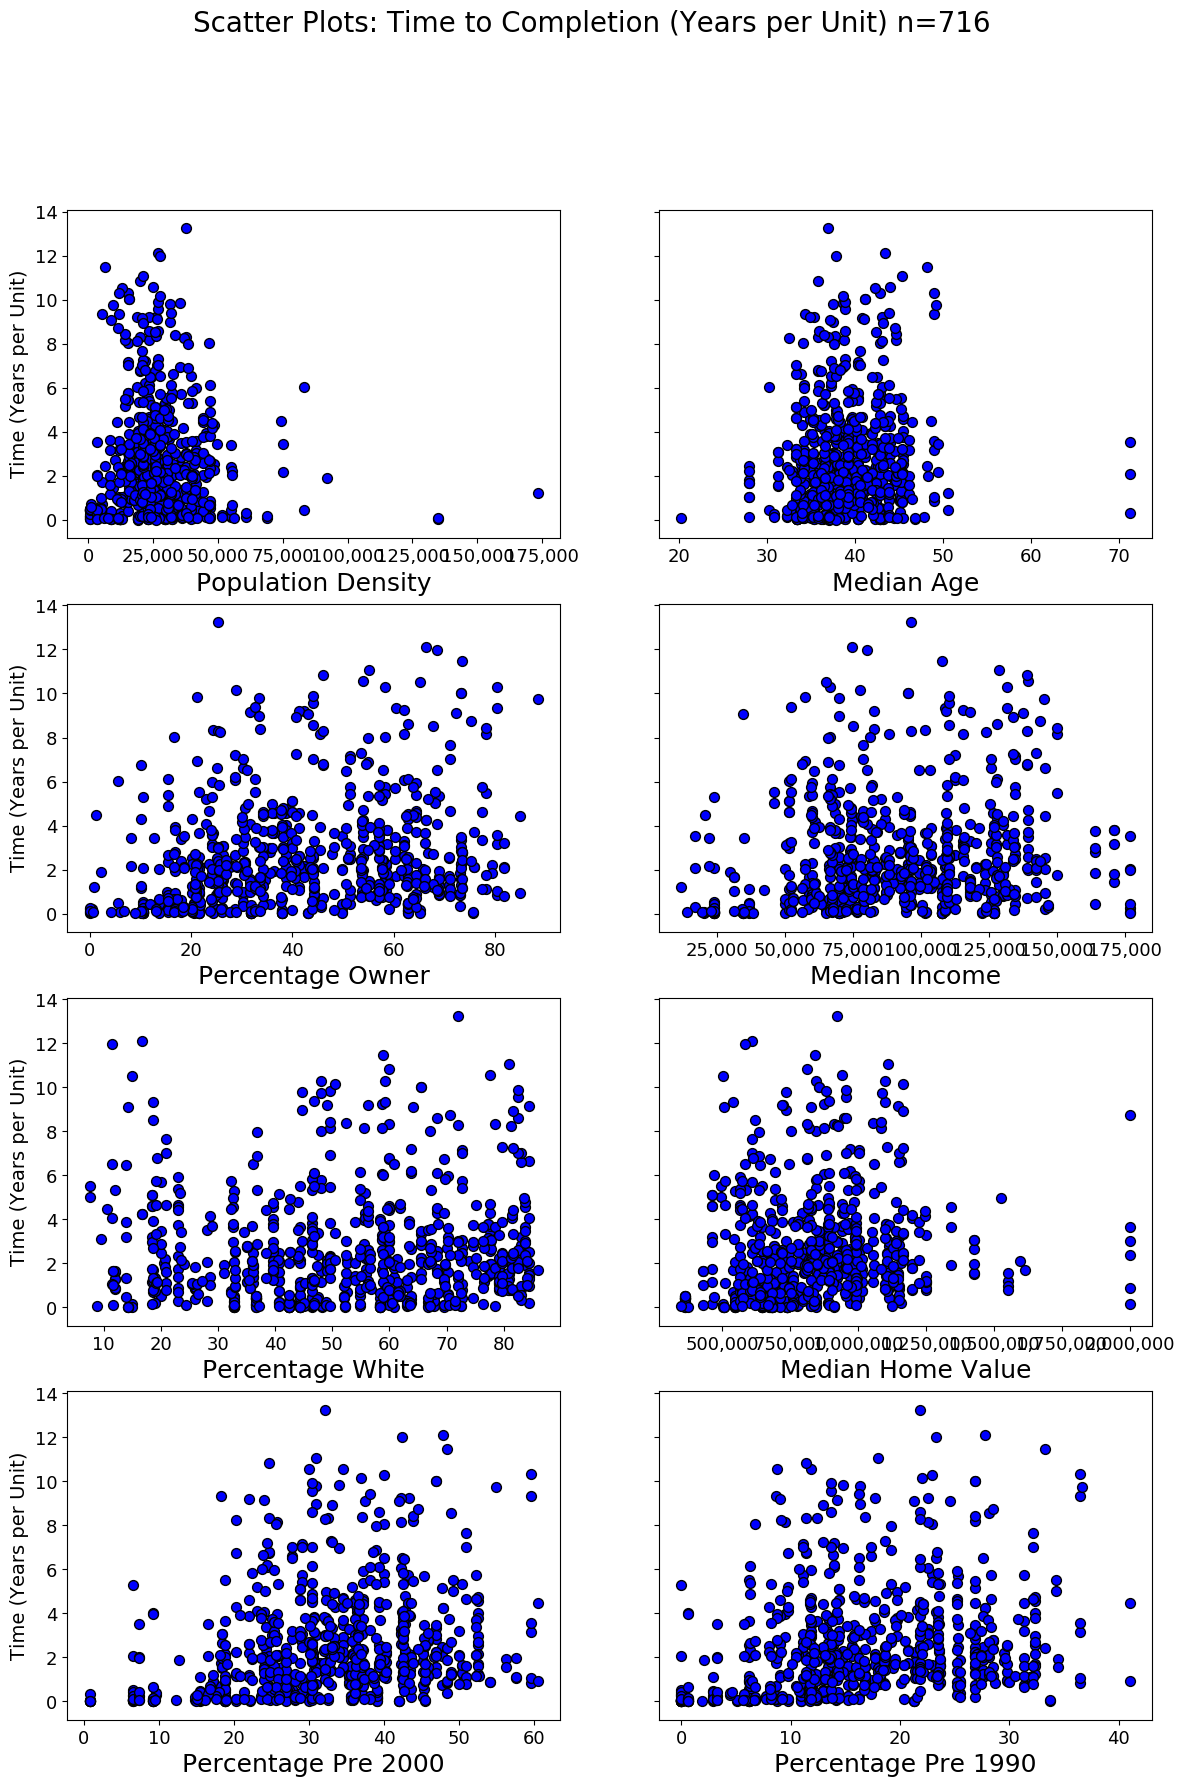

In [34]:
joint_scatter('years_per_unit', 'Scatter Plots: Time to Completion (Years per Unit)', 'Time (Years per Unit)', 'all_years_per_unit')

## Scatter Entitlement Times

In [35]:
df2 = df[pd.notnull(df['BP_date'])]

In [36]:
#scatter plots by entitlement times
df2['permit_time']=df2.apply(lambda x: ((dateutil.parser.parse(x['BP_date']) - dateutil.parser.parse(x['first_date'])).days)/365, axis=1)
df2['permit_time_per_unit']=df2['permit_time']/df2['units']

/Users/briangoggin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/briangoggin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


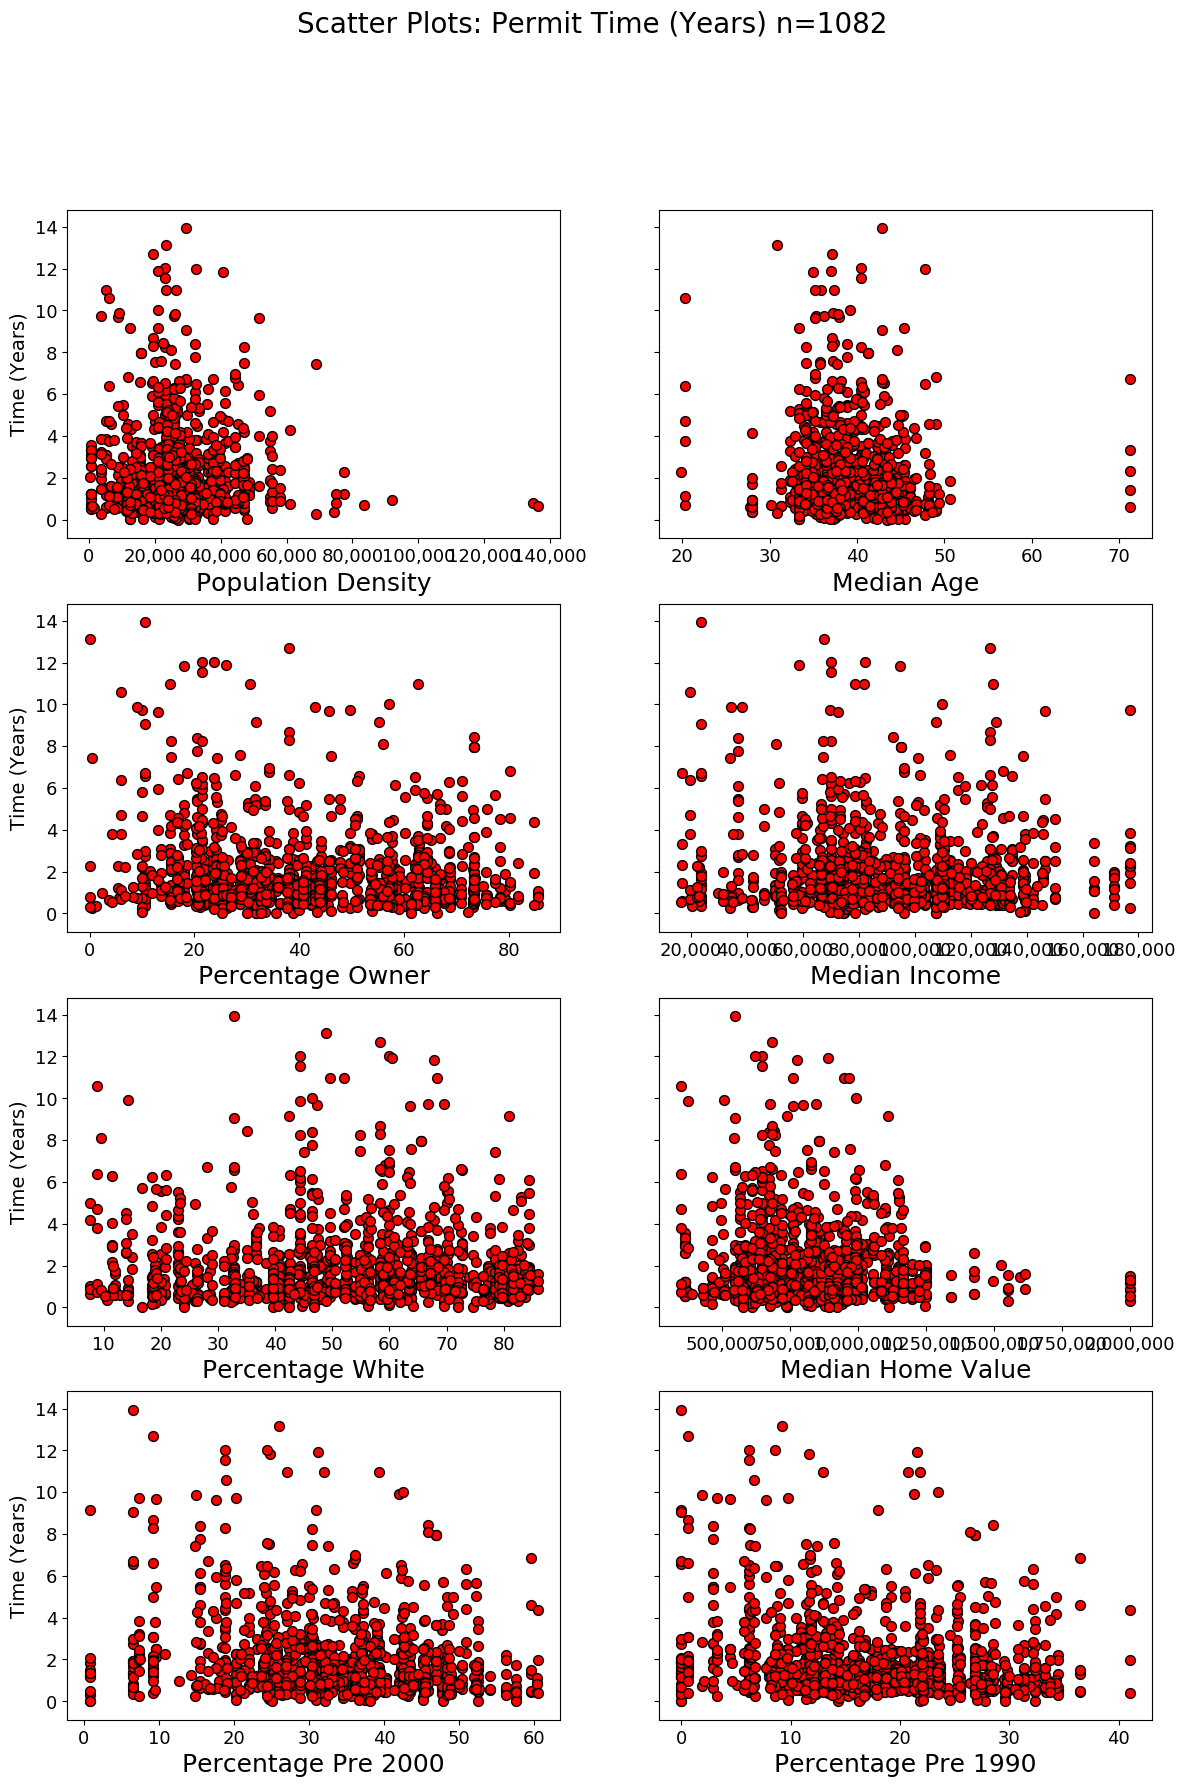

In [37]:
joint_scatter('permit_time', 'Scatter Plots: Permit Time (Years)', 'Time (Years)','all_ent_years', df=df2, color='red')

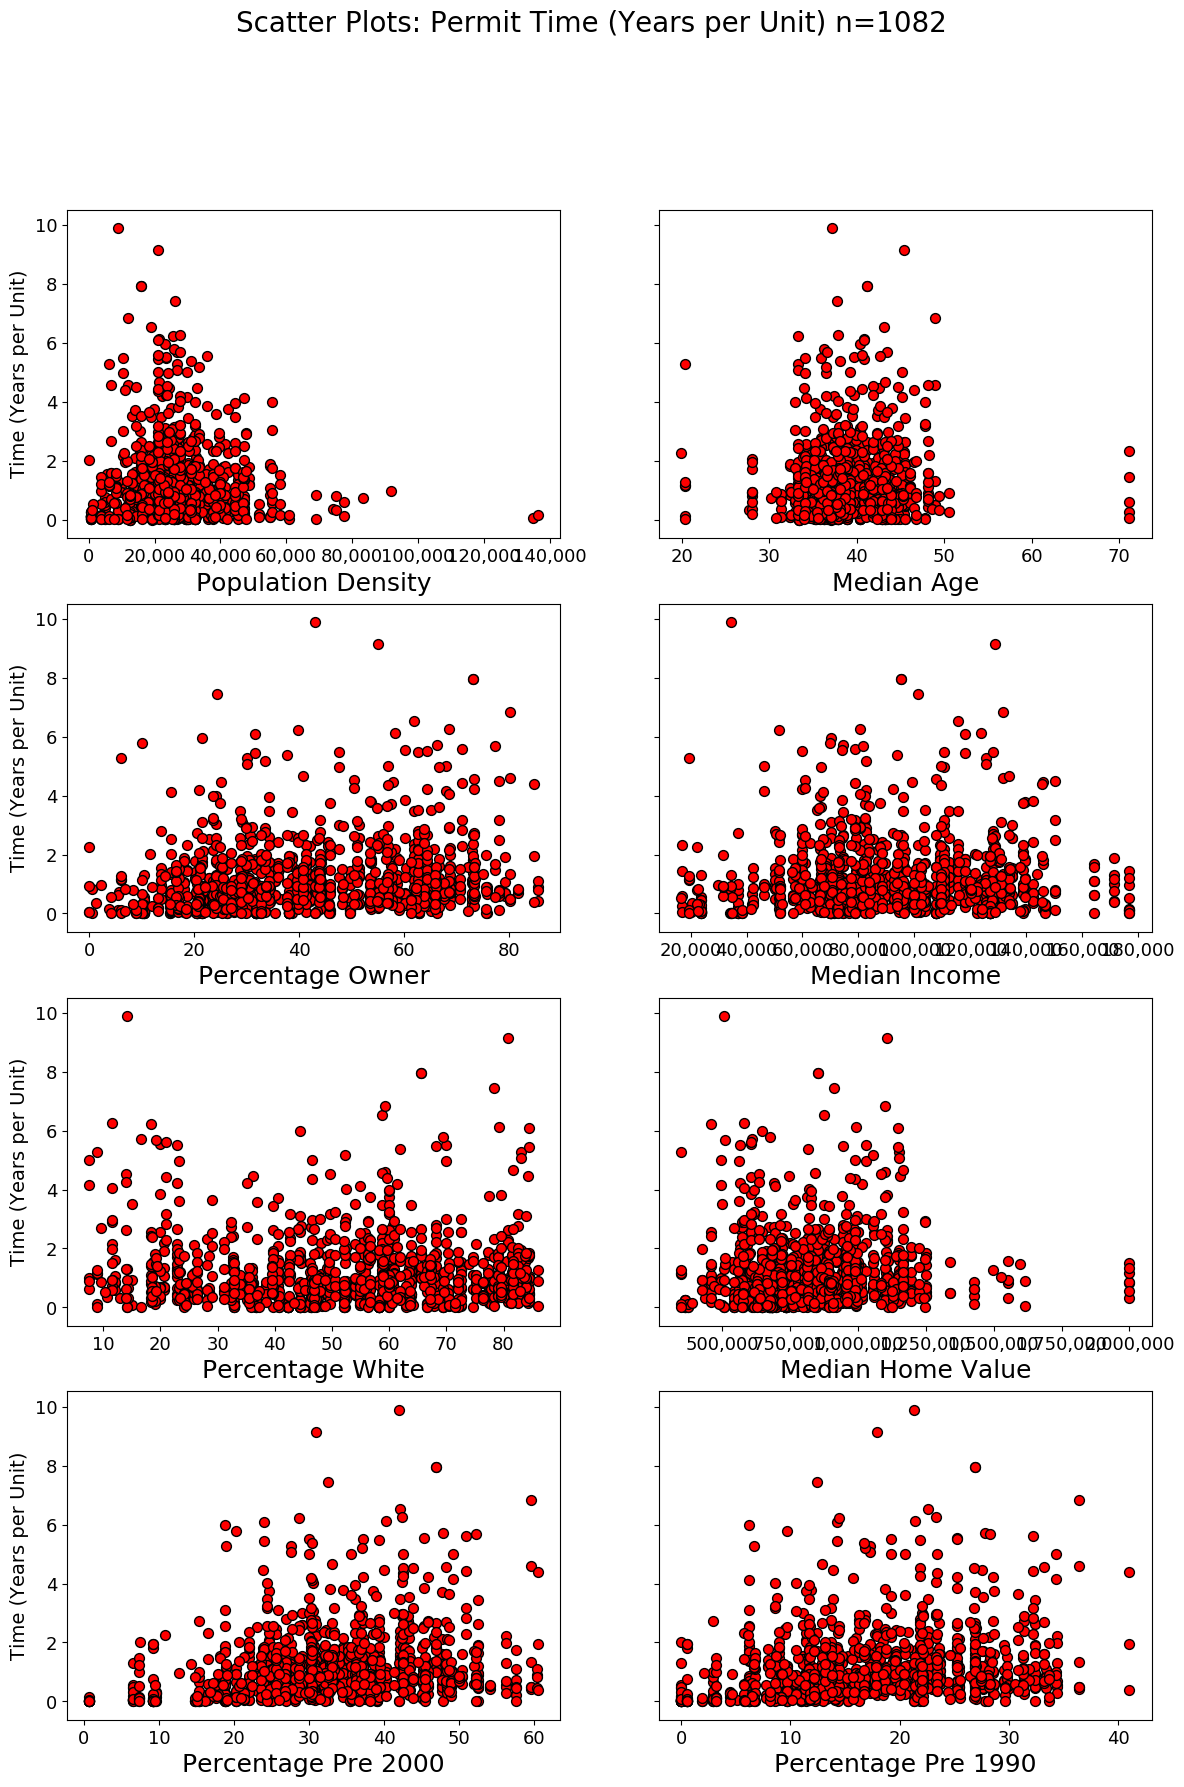

In [38]:
joint_scatter('permit_time_per_unit', 'Scatter Plots: Permit Time (Years per Unit)', 'Time (Years per Unit)','all_ent_years_per_unit', df=df2, color='red')

## Big Project Scatter Plots

In [39]:
df_big=df[df['units']>=10]

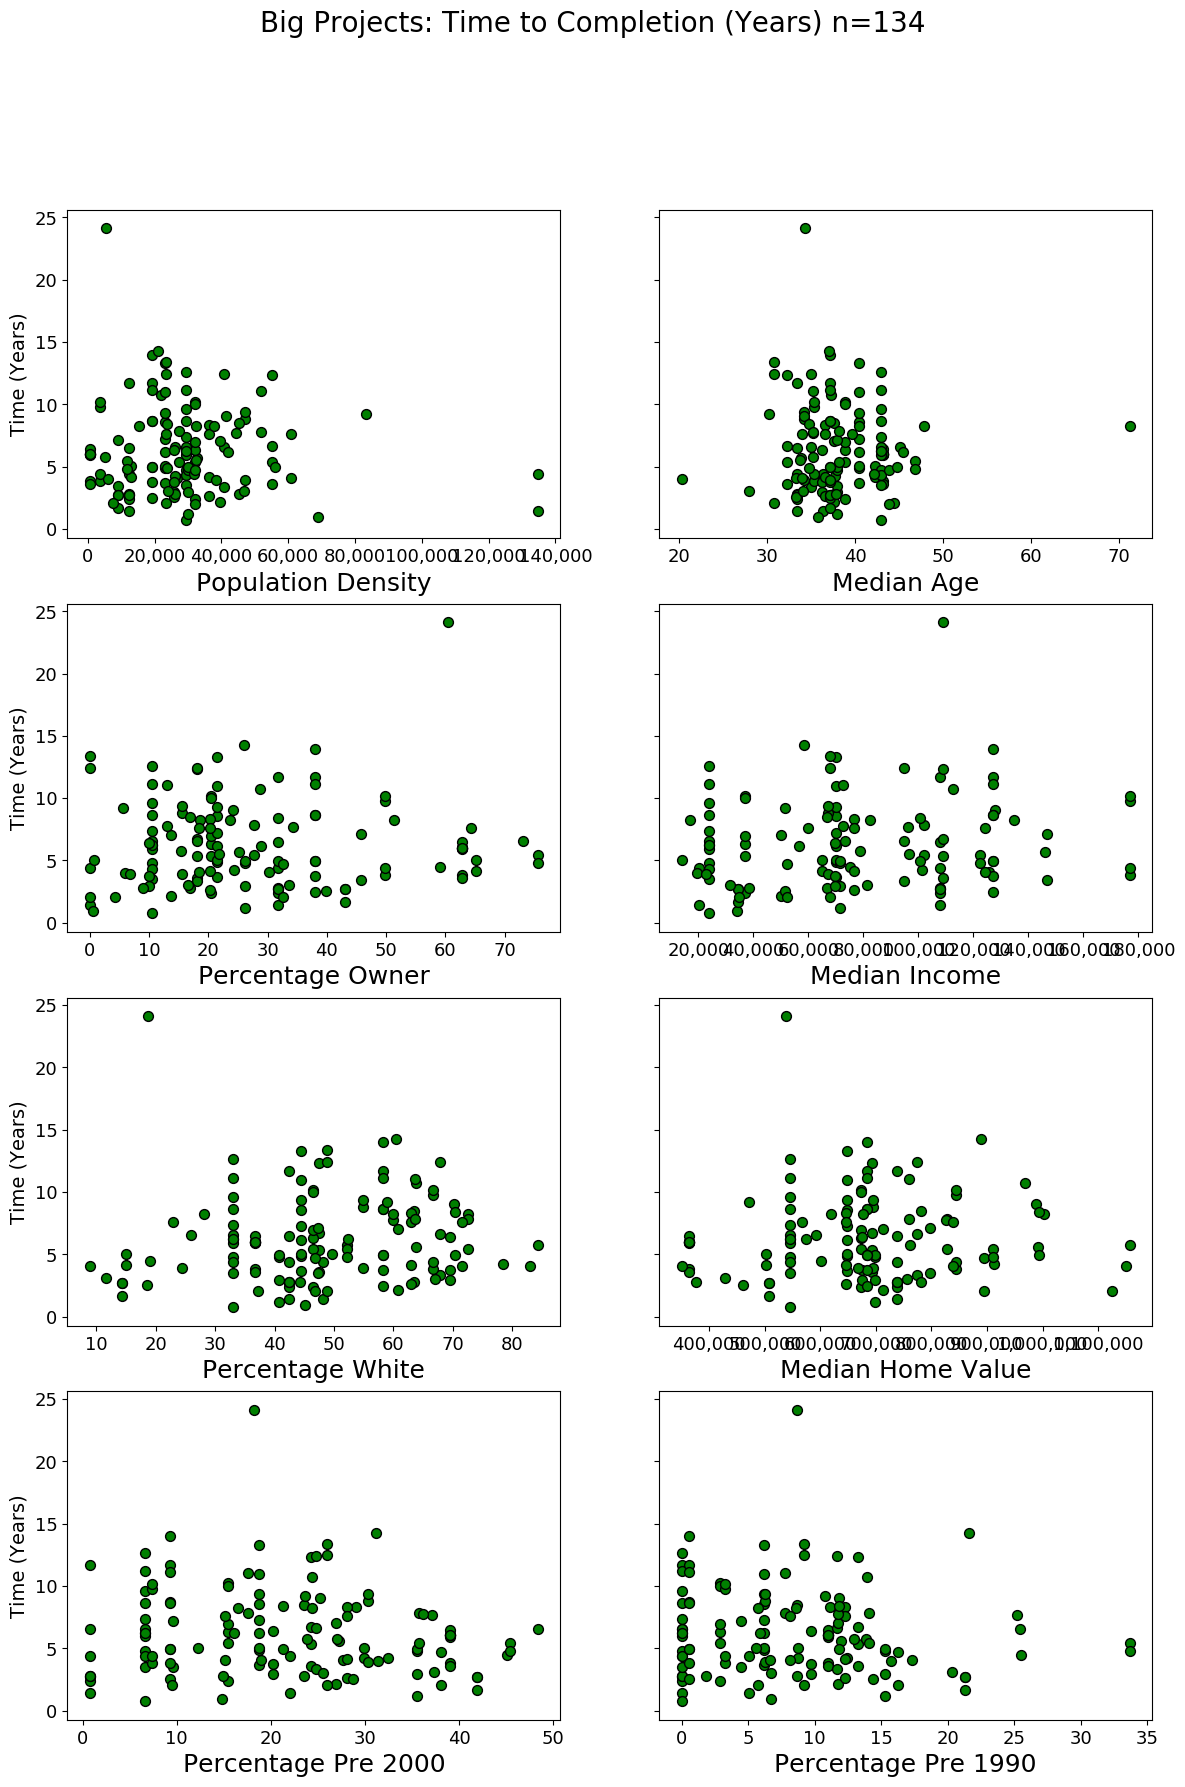

In [40]:
joint_scatter('project_time_years', 'Big Projects: Time to Completion (Years)', 'Time (Years)', 'big', df=df_big, color='green')

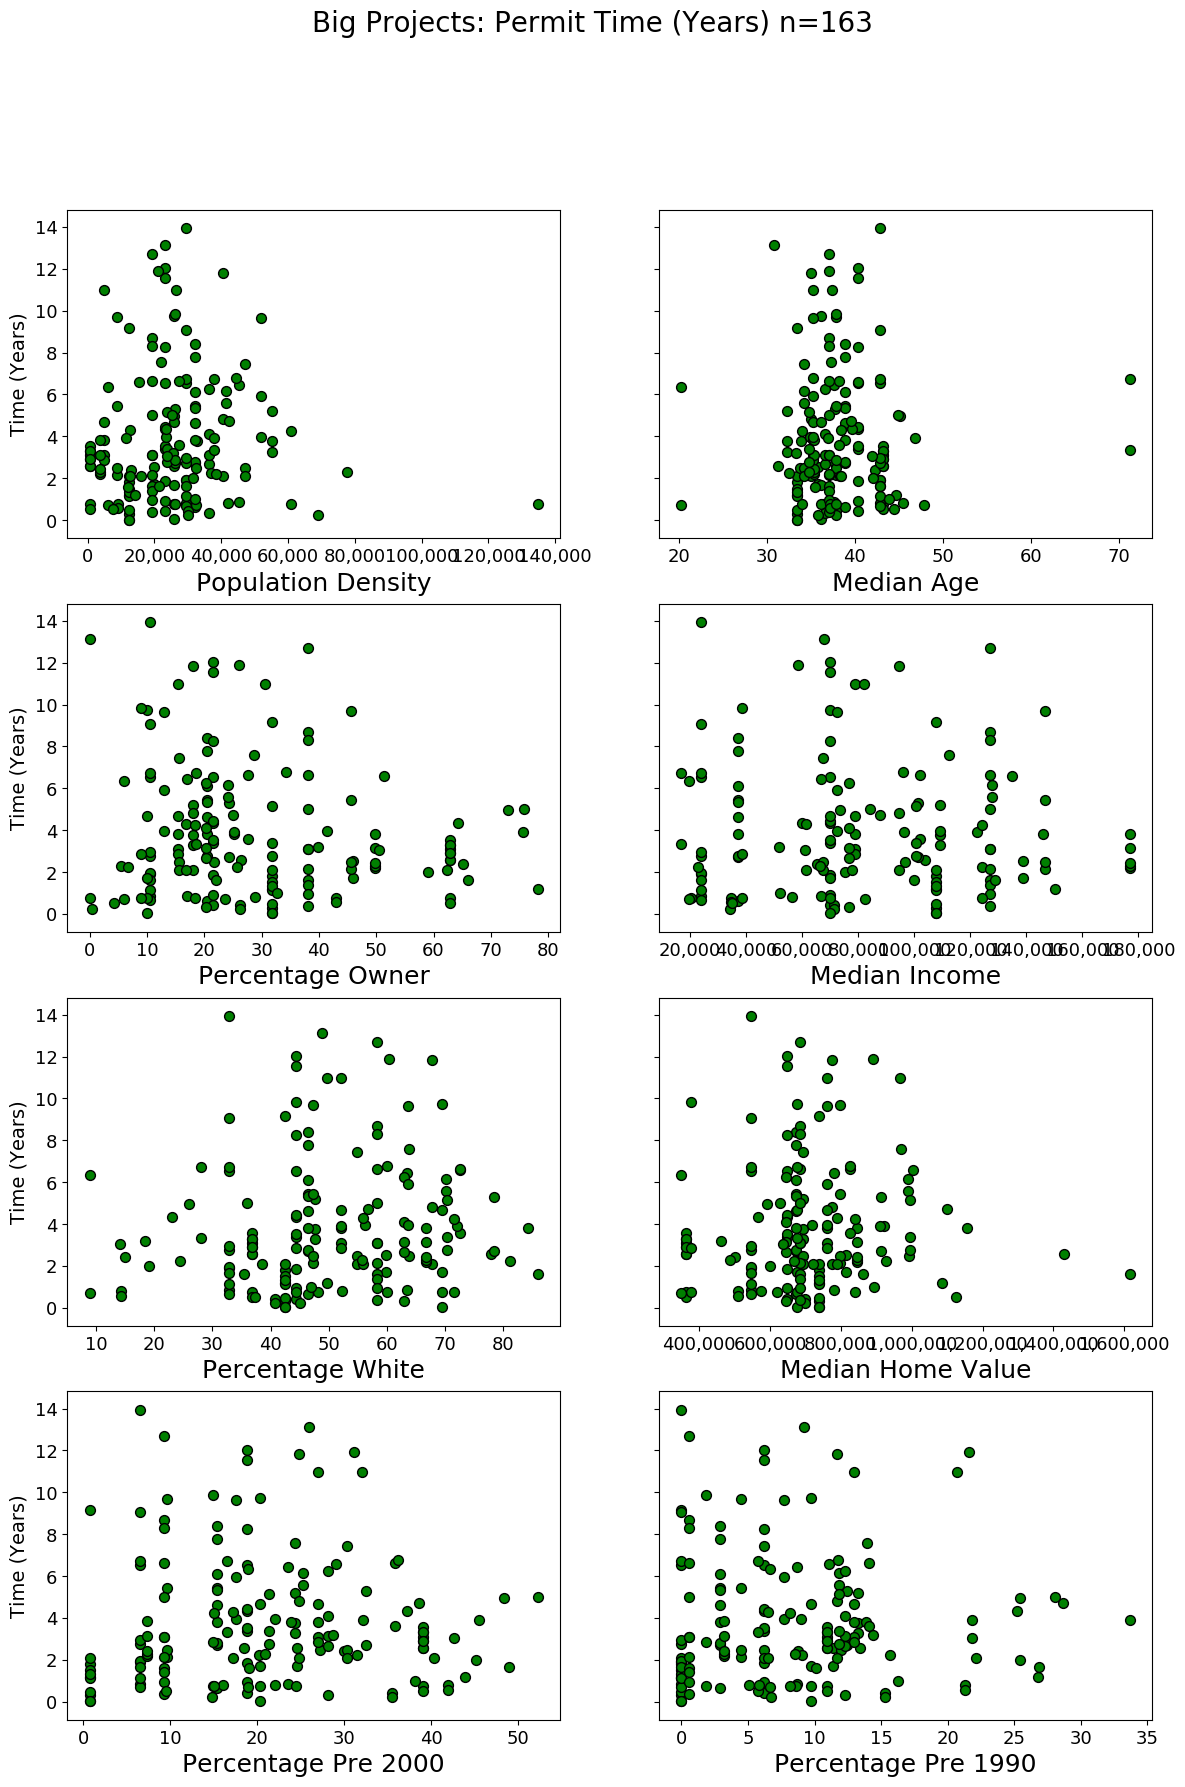

In [41]:
df_big=df_big[pd.notnull(df_big['BP_date'])] #drop all without BP date for permitting time graphs
df_big['permit_time']=df_big.apply(lambda x: ((dateutil.parser.parse(x['BP_date']) - dateutil.parser.parse(x['first_date'])).days)/365, axis=1)
joint_scatter('permit_time', 'Big Projects: Permit Time (Years)', 'Time (Years)', 'big_ent', df=df_big, color='green')

# Regressions

In [42]:
import statsmodels.formula.api as smf
import numpy as np
from sklearn import linear_model

In [43]:
df.head()

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,dropped_out,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,comp_year,permit_year,bp_duplicates,project_time_years,geometry,index_right,GEOID,perc_owner,pop_density,perc_old,perc_rich,perc_white,median_age,median_income,median_homevalue,perc_pre_2000,perc_pre_1990,years_per_unit
0,0,NaN,751 WEBSTER ST,0797003,2013-03-28,BP FILED,NaN,NaN,201303283273,True,2013-03-28,2013-03-28,2013-03-28,2013-03-28,BP FILED,"('2013-03-28', '2013-03-28', '2013-03-28', '20...",NaN,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",1,2016,Proposed,1.0,1.0,-122.430139,37.777629,RH-3,RH-3,,,False,NaN,POINT (-122.430139 37.7776287614),88,06075016300,20.221886,48699.174557,12.329656,19.943759,55.678131,34.0,86940.0,794000.0,33.383762,7.967726,NaN
291,0,NaN,890 GROVE ST,0797019,NaN,PL APPROVED,NaN,2014-05-27,201003107932,False,2010-02-16,2010-07-09,2010-02-16,NaN,PL APPROVED,"('2010-07-09', '2010-07-09', '2010-07-09', '20...",NaN,"('PL APPROVED', 'PL APPROVED', 'PL APPROVED', ...",2,2013,Proposed,1.0,1.0,-122.431228,37.776981,RH-3,RH-3,,,False,NaN,POINT (-122.431228 37.776981),88,06075016300,20.221886,48699.174557,12.329656,19.943759,55.678131,34.0,86940.0,794000.0,33.383762,7.967726,NaN
625,0,2016-06-10,628 IVY ST,0805034,2016-06-10,BP ISSUED,NaN,NaN,201504022691,False,2015-04-02,2015-04-02,2015-04-02,2016-06-10,BP ISSUED,"('2015-04-02', '2015-04-02', '2015-04-02', '20...",NaN,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",2,2017,Building Permit Approved,1.0,1.0,-122.428596,37.776775,NaN,NaN,,2016,False,NaN,POINT (-122.4285964966 37.7767753601),88,06075016300,20.221886,48699.174557,12.329656,19.943759,55.678131,34.0,86940.0,794000.0,33.383762,7.967726,NaN
2051,0,NaN,802-808 STEINER ST (BLDG 3 OF 3),0798055,2014-02-13,PL APPROVED,NaN,NaN,201109144616,True,2014-01-03,2014-02-13,2014-01-03,2014-02-13,PL APPROVED,"('2014-02-13',)",NaN,"('PL APPROVED',)",4,2016,Proposed,1.0,1.0,-122.432786,37.777030,RH-3,RH-3,,,False,NaN,POINT (-122.432786084 37.7770298898),88,06075016300,20.221886,48699.174557,12.329656,19.943759,55.678131,34.0,86940.0,794000.0,33.383762,7.967726,NaN
2107,0,2014-08-22,564 FELL ST,0819011,2015-05-07,CONSTRUCTION,10/01/2015,2015-05-07,201303283325,False,2013-03-28,2013-03-28,2013-03-28,2015-05-07,CONSTRUCTION,"('2013-03-28', '2013-03-28', '2013-03-28', '20...",917.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",3,2015,Under Construction,1.0,1.0,-122.427128,37.775597,RTO,RTO,2015,2014,False,2.512329,POINT (-122.427127741 37.7755972585),88,06075016300,20.221886,48699.174557,12.329656,19.943759,55.678131,34.0,86940.0,794000.0,33.383762,7.967726,2.512329


In [45]:
mod = smf.ols(formula='project_time_years ~ units + pop_density + median_age + median_income + median_homevalue + perc_pre_1990', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     project_time_years   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     8.843
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           2.64e-09
Time:                        10:27:12   Log-Likelihood:                -1722.9
No. Observations:                 690   AIC:                             3460.
Df Residuals:                     683   BIC:                             3492.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.0579      1.303  

In [46]:
mod = smf.ols(formula='permit_time ~ units  + pop_density + median_age + median_income + median_homevalue + perc_pre_1990', data=df2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            permit_time   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     16.60
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           2.35e-18
Time:                        10:27:16   Log-Likelihood:                -2192.6
No. Observations:                1056   AIC:                             4399.
Df Residuals:                    1049   BIC:                             4434.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.5705      0.621  

In [48]:
mod = smf.ols(formula='permit_time ~ units + median_age', data=df2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            permit_time   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     38.42
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           7.59e-17
Time:                        10:30:26   Log-Likelihood:                -2267.9
No. Observations:                1082   AIC:                             4542.
Df Residuals:                    1079   BIC:                             4557.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0712      0.495      6.202      0.0

In [50]:
mod = smf.ols(formula='years_per_unit ~ pop_density + median_age + median_income + median_homevalue + perc_pre_1990', data=df)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         years_per_unit   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     10.26
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           1.68e-09
Time:                        10:37:05   Log-Likelihood:                -1586.1
No. Observations:                 690   AIC:                             3184.
Df Residuals:                     684   BIC:                             3212.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5523      1.052  